# LEGO Detection - YOLO

### Libraries

In [1]:
# import libraries

import os
import cv2
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from google.colab import drive
from xml.etree import ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.ops.boxes as box_ops
from tqdm import tqdm
from torchvision.transforms import functional as F



In [2]:
# install ultralyticis
%pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
# import YOLO form ultralyrics
from ultralytics import YOLO

### Data preparation

In [4]:
# mount drive on colab notebook

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# unzip data files

!unzip "/content/drive/MyDrive/02 - tagged1.zip" -d "/content"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/renders/1/44570_Medium-Yellowish-green_5_1588263428.jpg  
  inflating: /content/renders/1/3066_White_1_1608402843.jpg  
  inflating: /content/renders/1/54383_Sand-Green_1_1588678909.jpg  
  inflating: /content/renders/1/4070_Light-Stone-Grey_8_1588631206.jpg  
  inflating: /content/renders/1/11399_Sand-Green_3_1587328912.jpg  
  inflating: /content/renders/1/99206_Medium-Yellowish-green_2_1587787565.jpg  
  inflating: /content/renders/1/2419_Spring-Yellowish-Green_7_1587826329.jpg  
  inflating: /content/renders/1/11211_Earth-Blue_0_1608628084.jpg  
  inflating: /content/renders/1/2419_Bright-Yellow_9_1588559103.jpg  
  inflating: /content/renders/1/3031_Earth-Green_3_1589236204.jpg  
  inflating: /content/renders/1/54384_Aqua_5_1589279145.jpg  
  inflating: /content/renders/1/6565_Bright-Red_1_1608931367.jpg  
  inflating: /content/renders/1/64799_Nougat_4_1587600029.jpg  
  inflating: /content/renders/1/

In [6]:
# major variables

photos_dir = '/content/photos'
renders_dir = '/content/renders'
image_resolution_after_preparation = 640

# photos_dir = 'content/photos' # running locally
# renders_dir = 'content/renders' # running locally

In [7]:
def load_data(data_dir):
    '''
    Returns a list of images and labels for each image
    '''
    image_paths = []
    num_legos = []
    for subdir, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg'):
                n = int(subdir.split(os.sep)[-1])
                image_paths.append(os.path.join(subdir, file))
                num_legos.append(n)
    combined = list(zip(image_paths, num_legos))
    combined.sort()
    image_paths, num_legos = zip(*combined)
    image_paths = np.asarray(image_paths)
    num_legos = torch.Tensor(num_legos).to(torch.int64)
    return image_paths, num_legos

In [8]:
def parse_xml(xml_file):
    '''
    Read the xml file and return the bounding box coordinates
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bounding_boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bounding_boxes.append([xmin, ymin, xmax, ymax])
    return bounding_boxes

In [9]:
def parse_all_xml(image_paths):
    '''
    Parse all XML files corresponding to the given image paths.
    '''
    bounding_boxes = []
    for img_path in image_paths:
        xml_path = img_path.replace('.jpg', '.xml')
        bounding_boxes.append(parse_xml(xml_path))
    return bounding_boxes

In [10]:
# load data

image_paths, num_legos = load_data(photos_dir)

['/content/photos/1/0_022X_original_1608916900045.jpg' '/content/photos/1/0_08Kx_original_1609011668789.jpg' '/content/photos/1/0_0GhB_original_1608917422072.jpg' ... '/content/photos/9/IMG_20201127_003720.jpg' '/content/photos/9/IMG_20201127_003725.jpg' '/content/photos/9/IMG_20201127_234032.jpg']


In [11]:
# parse bounding boxes for all images

bounding_boxes = parse_all_xml(image_paths)

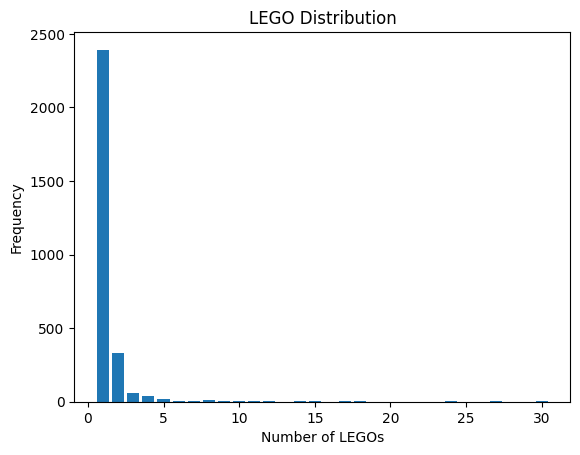

In [12]:
# class distribution in overall data

plt.hist(num_legos, bins=range(1, max(num_legos)), align='left', rwidth=0.8)
plt.xlabel('Number of LEGOs')
plt.ylabel('Frequency')
plt.title('LEGO Distribution')
plt.show()

In [13]:
# work with defined train test split

train_test_split = np.genfromtxt('/content/drive/MyDrive/train_test_split.csv', delimiter=',', dtype=None, encoding=None)
# train_test_split = np.genfromtxt('content/train_test_split.csv', delimiter=',', dtype=None, encoding=None) # running locally

train_test_ids = {
    'train': [],
    'test': []
}
for index, row in enumerate(train_test_split):
    if row[1] == '1':
      train_test_ids['test'].append(index - 1)
    elif row[1] == '0':
      train_test_ids['train'].append(index - 1)

len(train_test_ids['train']), len(train_test_ids['test'])

(2659, 274)

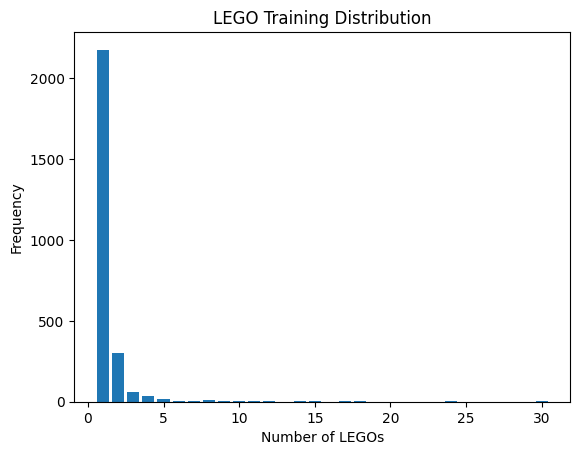

In [14]:
# class distribution in training data

num_legos_train = num_legos[train_test_ids['train']]
plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
plt.xlabel('Number of LEGOs')
plt.ylabel('Frequency')
plt.title('LEGO Training Distribution')
plt.show()

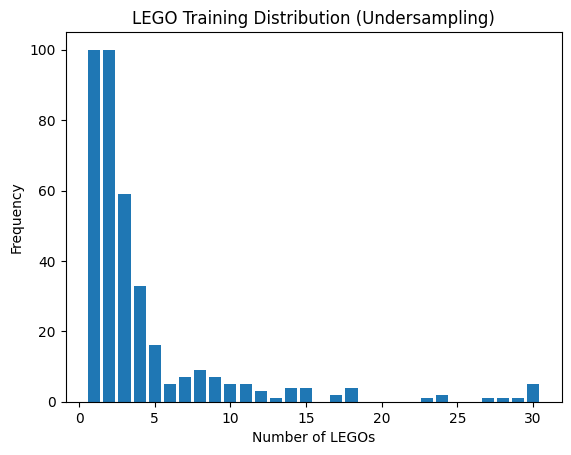

In [15]:
# undersampling of larger classes in training data

indices1 = []
indices2 = []

for i in train_test_ids['train']:
    if num_legos[i] == 1:
        indices1.append(i)
    elif num_legos[i] == 2:
        indices2.append(i)

np.random.shuffle(indices1, )
np.random.shuffle(indices2, )

leftovers1 = indices1[100:]
leftovers2 = indices2[100:]

for i in leftovers1:
    train_test_ids['train'].remove(i)
for i in leftovers2:
    train_test_ids['train'].remove(i)

num_legos_train = num_legos[train_test_ids['train']]
plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
plt.xlabel('Number of LEGOs')
plt.ylabel('Frequency')
plt.title('LEGO Training Distribution (Undersampling)')
plt.show()

In [16]:
# validation set

indices = train_test_ids['test']
np.random.shuffle(indices, )

test_size = 0.4 * len(indices)
split = int(np.floor(test_size))
train_test_ids['valid'], train_test_ids['test'] = indices[split:], indices[:split]

len(train_test_ids['train']), len(train_test_ids['valid']), len(train_test_ids['test'])

(378, 165, 109)

In [17]:
# bounding boxes for train, valid, and test sets

train_boxes = [bounding_boxes[i] for i in train_test_ids['train']]
valid_boxes = [bounding_boxes[i] for i in train_test_ids['valid']]
test_boxes = [bounding_boxes[i] for i in train_test_ids['test']]




In [18]:
class LegosDataset(Dataset):
    '''
    Dataset class for the legos dataset
    '''
    def __init__(self, images_filenames, num_legos, bounding_boxes, transforms=[], augmented=[]):
        self.images_filenames = images_filenames
        self.labels = num_legos
        self.bounding_boxes = bounding_boxes
        self.transforms = transforms
        self.augmented = augmented

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, id):
        image_filename = self.images_filenames[id]
        label = self.labels[id]
        bounding_boxes = self.bounding_boxes[id]
        image = cv2.imread(image_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width = image.shape[:2]
        transformation = self.transforms[self.augmented[id]]
        image = transformation(image)
        scale_w = 640.0 / original_width
        scale_h = 640.0 / original_height
        scaled_boxes = []
        for box in bounding_boxes:
            x_min, y_min, x_max, y_max = box
            x_min = int(x_min * scale_w)
            y_min = int(y_min * scale_h)
            x_max = int(x_max * scale_w)
            y_max = int(y_max * scale_h)
            scaled_boxes.append([x_min, y_min, x_max, y_max])
        target = {
            'boxes': torch.tensor(scaled_boxes, dtype=torch.float32),
            'labels': torch.ones((label,), dtype=torch.int64)
        }
        return image, target

In [19]:
# train, valid and test sets

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = LegosDataset(image_paths[train_test_ids['train']], num_legos[train_test_ids['train']], train_boxes,
                             transforms=[transform, augment], augmented=[0]*len(image_paths[train_test_ids['train']]))

valid_dataset = LegosDataset(image_paths[train_test_ids['valid']], num_legos[train_test_ids['valid']], valid_boxes,
                             transforms=[transform], augmented=[0]*len(image_paths[train_test_ids['valid']]))

test_dataset = LegosDataset(image_paths[train_test_ids['test']], num_legos[train_test_ids['test']], test_boxes,
                            transforms=[transform], augmented=[0]*len(image_paths[train_test_ids['test']]))

In [20]:
def generate_data(image_paths, num_legos, bounding_boxes, copies=5):
    '''
    Generate more data by copying images with more than 6 legos
    '''
    new_image_paths = []
    new_num_legos = []
    new_bounding_boxes = []
    for id in range(len(image_paths)):
        if num_legos[id] >= 6:
            for n in range(copies):
                new_image_paths.append(image_paths[id])
                new_num_legos.append(num_legos[id])
                new_bounding_boxes.append(bounding_boxes[id])
    return new_image_paths, new_num_legos, new_bounding_boxes

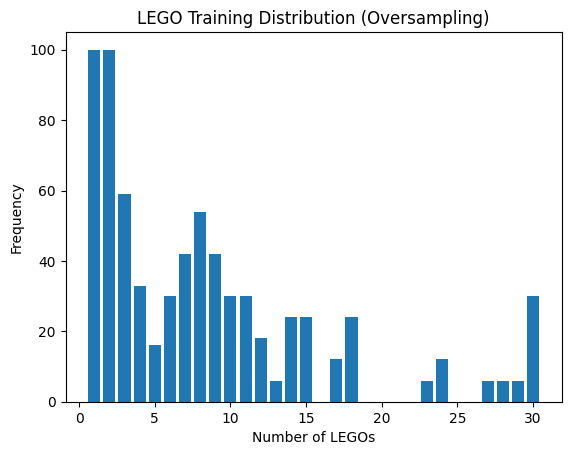

In [21]:
# oversampling of smaller classes in training data - augmentation

new_image_paths, new_num_legos, new_bounding_boxes = generate_data(
                                                        image_paths[train_test_ids['train']],
                                                        num_legos[train_test_ids['train']],
                                                        train_boxes
                                                    )

for img, lbl, bbox in zip(new_image_paths, new_num_legos, new_bounding_boxes):
    train_dataset.images_filenames = np.append(train_dataset.images_filenames, img)
    train_dataset.labels = torch.cat((train_dataset.labels, torch.tensor([lbl], dtype=torch.int64)))
    train_dataset.bounding_boxes.append(bbox)

train_dataset.augmented.extend([1] * len(new_image_paths))

num_legos_train = train_dataset.labels
plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
plt.xlabel('Number of LEGOs')
plt.ylabel('Frequency')
plt.title('LEGO Training Distribution (Oversampling)')
plt.show()

In [22]:
# dataloaders

batch_size = 16
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

len(train_dataset), len(valid_dataset), len(test_dataset)

(728, 165, 109)

In [27]:
# neet to create 3 pasts, train, valid and test. Inside each of them, create images and labels folders

# create folders
os.makedirs('/content/parts/train/images', exist_ok=True)
os.makedirs('/content/parts/train/labels', exist_ok=True)

os.makedirs('/content/parts/val/images', exist_ok=True)
os.makedirs('/content/parts/val/labels', exist_ok=True)

os.makedirs('/content/parts/test/images', exist_ok=True)
os.makedirs('/content/parts/test/labels', exist_ok=True)

#Now populate the folders with the images and labels

def populate_folder(dataloader, folder):
    for i, (images, targets) in enumerate(dataloader):
        for j, image in enumerate(images):
            img = F.to_pil_image(image)
            img.save(os.path.join(folder, 'images', f'{i}_{j}.jpg'))
            with open(os.path.join(folder, 'labels', f'{i}_{j}.txt'), 'w') as f:
                for box in targets[j]['boxes']:
                    x_min, y_min, x_max, y_max = box
                    x_center = (x_min + x_max) / 2.0 / 640
                    y_center = (y_min + y_max) / 2.0 / 640
                    width = (x_max - x_min) / 640
                    height = (y_max - y_min) / 640
                    f.write(f'0 {x_center} {y_center} {width} {height}\n')

populate_folder(train_dataloader, '/content/parts/train')
populate_folder(valid_dataloader, '/content/parts/val')
populate_folder(test_dataloader, '/content/parts/test')

data_yaml = """
names:
  0: Lego
nc: 1
train: /content/parts/train/images
val: /content/parts/val/images
test: /content/parts/test/images
"""

with open('/content/parts/data.yaml', 'w') as f:
    f.write(data_yaml)


In [28]:
!yolo task=detect mode=train model=yolov8m.pt data="/content/parts"/data.yaml epochs=25 imgsz=640 name=yoloV8Lego

100% 49.7M/49.7M [00:00<00:00, 349MB/s]
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/parts/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yoloV8Lego, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

In [32]:
!yolo task=detect mode=val model=runs/detect/yoloV8Lego/weights/best.pt name=yolov8Lego_eval data="/content/parts"/data.yaml imgsz=640

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/parts/val/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100% 165/165 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 11/11 [00:06<00:00,  1.65it/s]
                   all        165        386      0.922      0.881       0.94      0.846
Speed: 2.5ms preprocess, 20.4ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/yolov8Lego_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


In [34]:
!yolo task=detect mode=predict model=runs/detect/yoloV8Lego/weights/best.pt name=yolov8Lego_test source="/content/parts/test/images" imgsz=640

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/109 /content/parts/test/images/0_0.jpg: 640x640 1 Lego, 37.1ms
image 2/109 /content/parts/test/images/0_1.jpg: 640x640 1 Lego, 37.1ms
image 3/109 /content/parts/test/images/0_10.jpg: 640x640 2 Legos, 37.0ms
image 4/109 /content/parts/test/images/0_11.jpg: 640x640 25 Legos, 37.0ms
image 5/109 /content/parts/test/images/0_12.jpg: 640x640 1 Lego, 37.0ms
image 6/109 /content/parts/test/images/0_13.jpg: 640x640 2 Legos, 37.1ms
image 7/109 /content/parts/test/images/0_14.jpg: 640x640 2 Legos, 31.6ms
image 8/109 /content/parts/test/images/0_15.jpg: 640x640 3 Legos, 24.4ms
image 9/109 /content/parts/test/images/0_2.jpg: 640x640 1 Lego, 24.4ms
image 10/109 /content/parts/test/images/0_3.jpg: 640x640 2 Legos, 24.5ms
image 11/109 /content/parts/test/images/0_4.jpg: 640x640 3 Legos, 24.4ms
image 12/109 /content/parts/test/i

In [36]:
!yolo task=detect mode=train model=yolov9c.pt data="/content/parts"/data.yaml epochs=25 imgsz=640 name=yoloV9Lego

100% 49.4M/49.4M [00:00<00:00, 322MB/s]
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/parts/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yoloV9Lego, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

In [38]:
!yolo task=detect mode=val model=runs/detect/yoloV9Lego/weights/best.pt name=yolov9Lego_eval data="/content/parts"/data.yaml imgsz=640

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25320019 parameters, 0 gradients, 102.3 GFLOPs
val: Scanning /content/parts/val/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100% 165/165 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 11/11 [00:08<00:00,  1.34it/s]
                   all        165        386      0.919      0.877       0.94      0.846
Speed: 1.6ms preprocess, 29.9ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/yolov9Lego_eval2
💡 Learn more at https://docs.ultralytics.com/modes/val
